In [ ]:
from scipy.special import spherical_jn,spherical_yn



In [66]:
import numpy as np
from scipy.integrate import simpson
from ase import units
def radial_wfc_numerov(r0, n=1, l=0, Z=1, du=0.001,E=-1,vr=None):
    '''
    Numerov algorithm
    
                  [12 - 10f(n)]*y(n) - y(n-1)*f(n-1)
        y(n+1) = ------------------------------------
                               f(n+1)

    where
        
        f(n) = 1 + (h**2 / 12)*g(n)

        g(n) = [E + (2*Z / x) - l*(l+1) / x**2]
    '''

    ur = np.zeros(r0.size)
    fn = np.zeros(r0.size)
    gn = np.ones(r0.size)*E

    ur[0] = 0.0
    ur[1] = du

    dr  = r0[1] - r0[0]
    h12 = dr**2 / 12.

    mask = r0*units.Bohr>1.2*Z**(1/3)/100
    gn[mask] = (E + 2*vr[mask] / r0[mask] - l*(l+1) / r0[mask]**2)
    fn = 1. + h12 * gn

    for ii in range(2,r0.size-1,1):
        ur[ii] = (12 - 10*fn[ii-1]) * ur[ii-1] - \
                 ur[ii-2] * fn[ii-2]
        ur[ii] /= fn[ii]

    # normalization
    ur /= np.sqrt(simpson(ur**2, x=r0))

In [70]:
r0 = np.linspace(0.01, 50, 1000)
test=radial_wfc_numerov(r0,E=1,vr=np.ones(r0.size))
test

ValueError: x, y, and format string must not be None

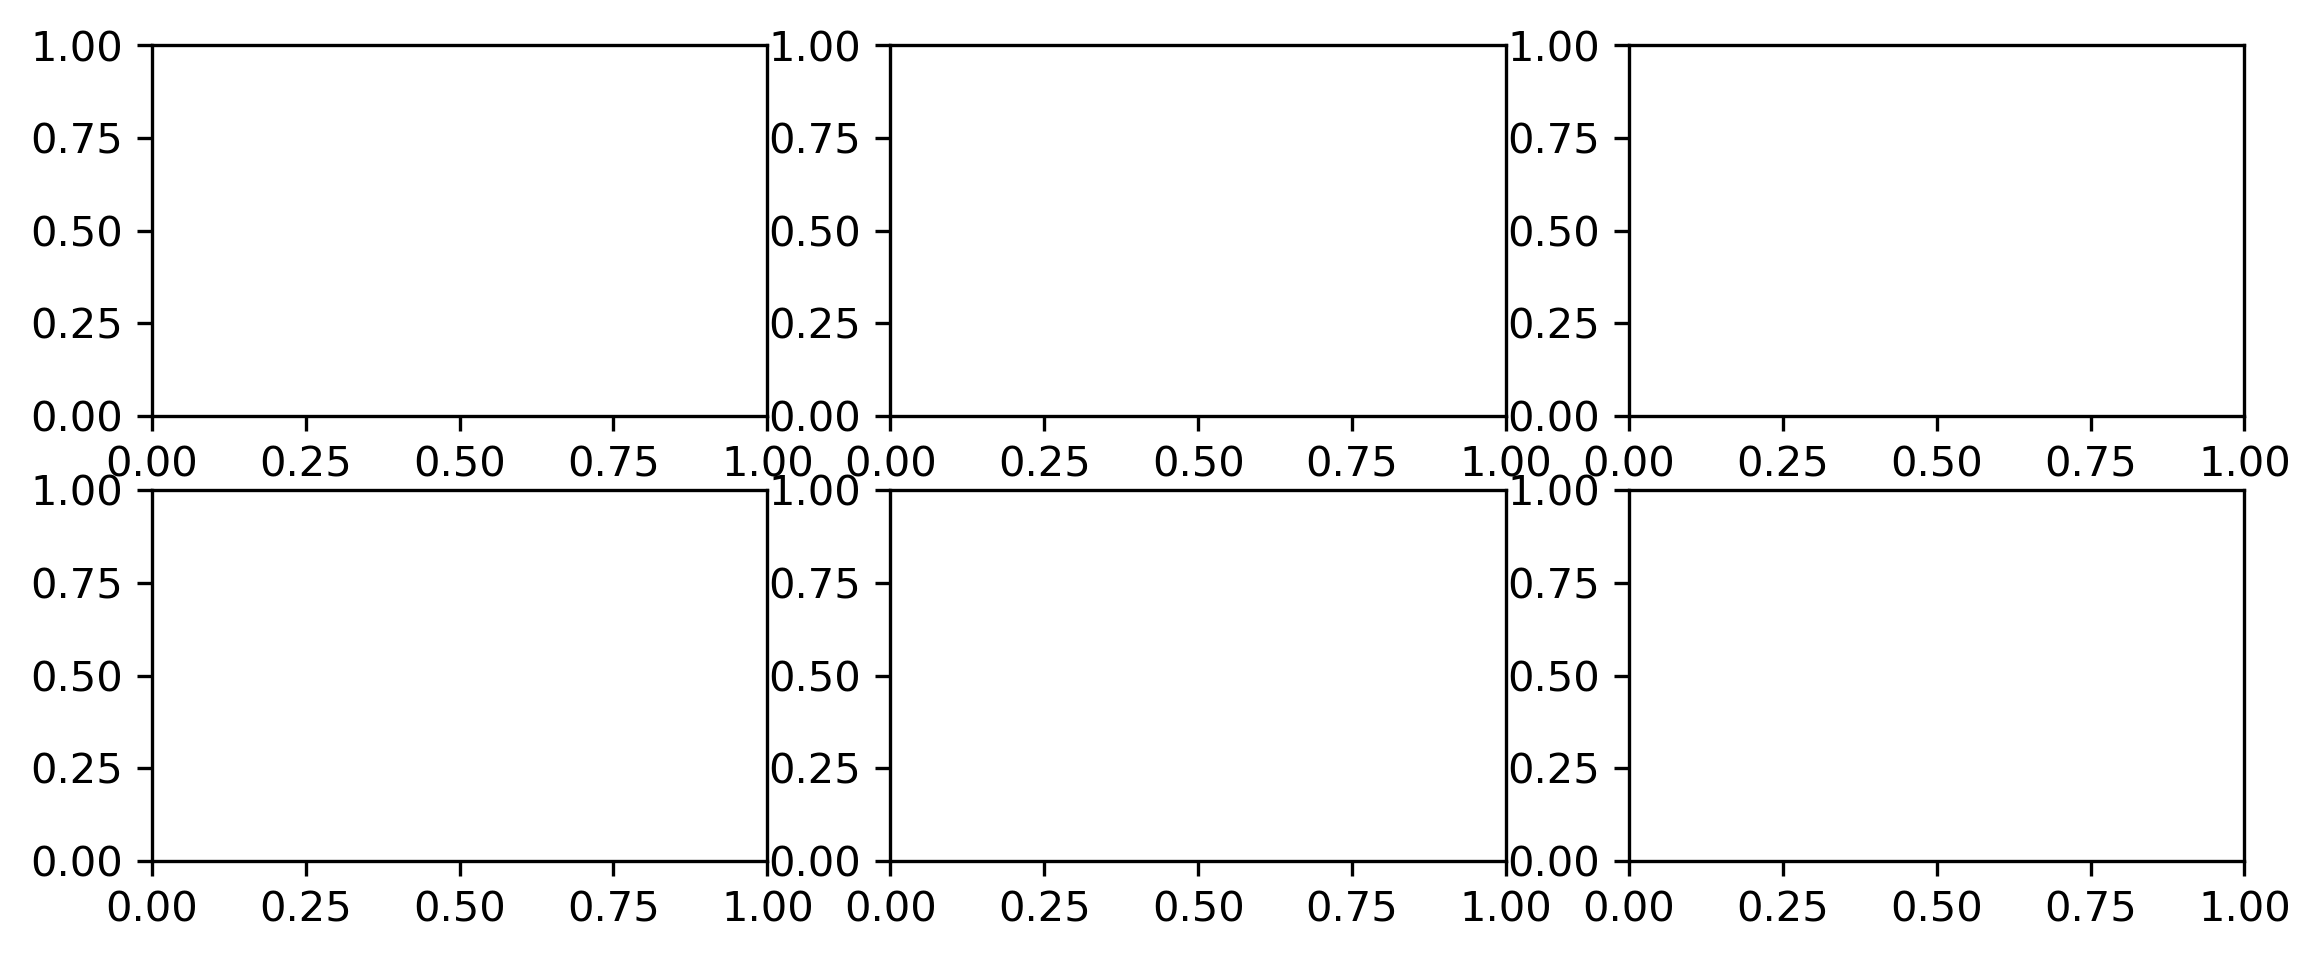

In [61]:
import matplotlib.pyplot as plt
from sympy import lambdify
from sympy.abc import r, Z
from sympy.physics.hydrogen import R_nl
r0 = np.linspace(0, 50, 1000)
nls = [
    (1, 0),
    (2, 0),
    (2, 1),
    (3, 0),
    (3, 1),
    (3, 2)
]
ur0 = [
    lambdify((r, Z), r * R_nl(n, l, r, Z), 'numpy')(r0, 1) for n, l in nls
]
deltas = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
ur2 = [radial_wfc_numerov(r0, n, l, du=deltas[ii]) for ii, (n, l) in enumerate(nls)]

################################################################################
fig = plt.figure(
    figsize=(9.0, 3.6),
    dpi=300
)
axes = [plt.subplot(2, 3 ,ii+1) for ii in range(len(nls))]

for ii in range(len(nls)):
    ax = axes[ii]

    ax.plot(r0, ur2[ii],
        ls='none',
        ms=3, marker='o', mfc='white', mew=1.0, 
        color=plt.rcParams['axes.prop_cycle'].by_key()['color'][ii],
        zorder=1,
        label=r'Numerov',
        )

    ax.plot(r0, ur0[ii], lw=0.6, color='cyan', zorder=2,
        label=r'Exact')

    ax.set_xlabel(r'$r$ [$a_0$]',   labelpad=5)
    ax.set_ylabel(r'$u_{{ {}{} }}(r)$'.format(*nls[ii]), labelpad=5)

    ax.legend(loc='best', fontsize='small', ncol=1)

    ax.set_xlim(-2, 16 + ii * 8)
    # print(str(nls[ii]))
    # ax.set_title(str(nls[ii]))

plt.tight_layout()
plt.savefig('fig2.png')
plt.show()

In [54]:
ur3 = radial_wfc_numerov(r0, 1, 0,Z=1)
ur3